# Imports

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import pathlib
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data_dir = "C:\\Users\\atcho\\Downloads\\car_data\\data"

# Data preparation

In [4]:
data_dir = pathlib.Path(data_dir)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [6]:
validation_df = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_df)
test_dataset = validation_df.take(val_batches // 5)
validation_dataset = validation_df.skip(val_batches // 5)

In [8]:
len(test_dataset.take(1))

1

In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['non-vehicles' 'vehicles']


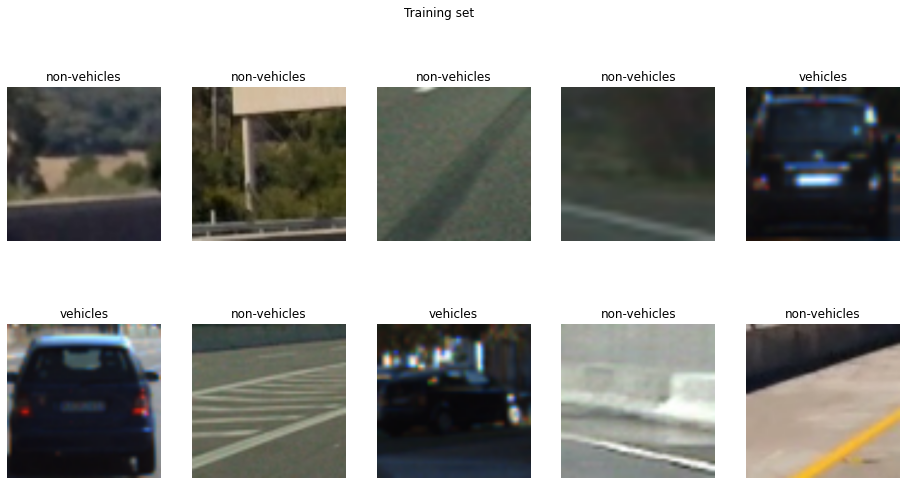

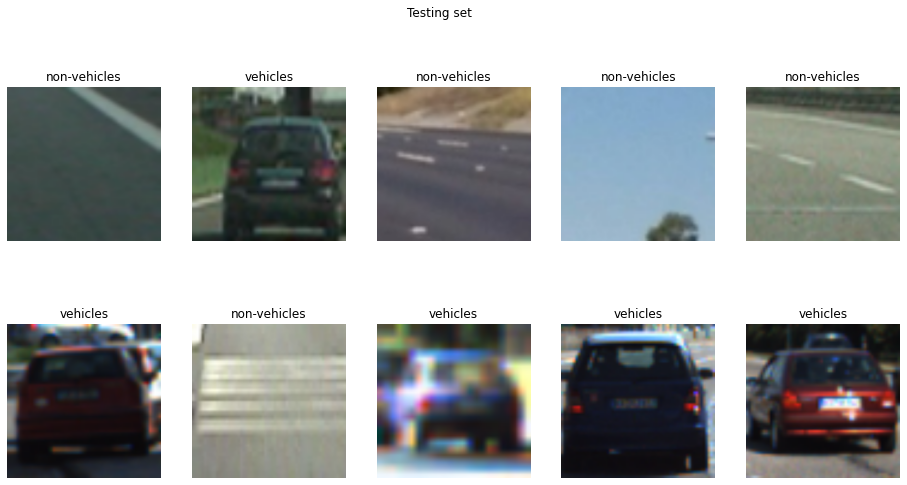

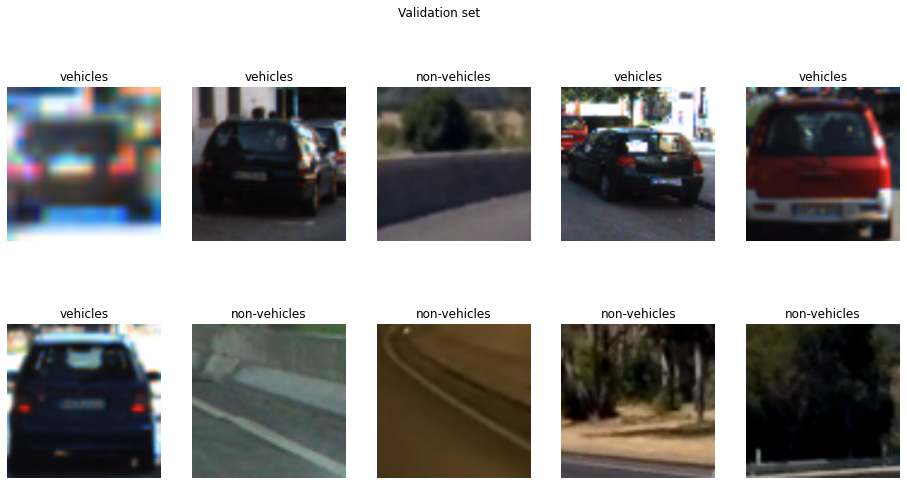

In [10]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Training set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in test_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Testing set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in validation_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Validation set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

# Import pre trained model

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [12]:
pretrained_model_res = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg',classes=2)

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [14]:
for layer in pretrained_model.layers:
        layer.trainable=False

In [15]:
for layer in pretrained_model_res.layers:
        layer.trainable=False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

[good doc](https://stackoverflow.com/questions/55929401/how-to-specify-model-compile-for-binary-crossentropy-activation-sigmoid-and-act)

[the meaning of logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)

In [17]:
model = pretrained_model.output
model = global_average_layer(model)
model = tf.keras.layers.Dropout(0.2)(model)
model = Dense(1)(model)
model = tf.keras.Model(inputs = pretrained_model.input , outputs = model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [21]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [24]:
initial_epochs = 6

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stop])

Epoch 1/6
444/444 [==============================] - 334s 744ms/step - loss: 0.5199 - accuracy: 0.7256 - val_loss: 0.3146 - val_accuracy: 0.8852
Epoch 2/6
444/444 [==============================] - 309s 696ms/step - loss: 0.2768 - accuracy: 0.8977 - val_loss: 0.2228 - val_accuracy: 0.9252
Epoch 3/6
444/444 [==============================] - 298s 670ms/step - loss: 0.2124 - accuracy: 0.9273 - val_loss: 0.1823 - val_accuracy: 0.9417
Epoch 4/6
444/444 [==============================] - 301s 679ms/step - loss: 0.1791 - accuracy: 0.9398 - val_loss: 0.1578 - val_accuracy: 0.9505
Epoch 5/6
444/444 [==============================] - 289s 651ms/step - loss: 0.1593 - accuracy: 0.9477 - val_loss: 0.1446 - val_accuracy: 0.9519
Epoch 6/6
444/444 [==============================] - 301s 678ms/step - loss: 0.1452 - accuracy: 0.9497 - val_loss: 0.1308 - val_accuracy: 0.9558


In [ ]:
# model2 = Sequential()
# model2.add(pretrained_model_res)
# # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model2.add(Dense(1, activation='softmax'))

In [ ]:
# model2.summary()

In [ ]:
# base_learning_rate = 0.0001
# model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [36]:
# initial_epochs = 6

# history2 = model2.fit(train_dataset,
#                     epochs=initial_epochs,
#                     validation_data=validation_dataset,
#                     callbacks=[early_stop])

Epoch 1/6
 11/444 [..............................] - ETA: 18:19 - loss: 0.6770 - accuracy: 0.4716

KeyboardInterrupt: 

# Evaluation

## MobileNet model

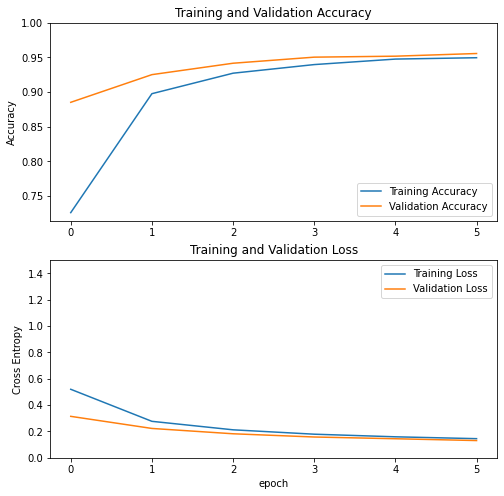

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [78]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [79]:
predictions

array([-2.1981425 , -5.217158  ,  2.9525723 , -3.4741178 ,  2.3383198 ,
        3.622015  ,  3.3658278 ,  4.2494016 , -1.7928869 ,  3.6009336 ,
        4.2982707 ,  2.6483061 , -4.8903546 ,  4.719128  ,  3.9703407 ,
        4.770653  ,  2.2667024 ,  3.8809066 ,  5.8184013 ,  5.2261653 ,
       -4.3659725 ,  0.80571324, -5.3284364 ,  2.6378493 ,  0.5536912 ,
        2.8697345 ,  3.8015165 , -4.352426  ,  5.4530587 ,  4.4961047 ,
        3.5071902 , -3.8473377 ], dtype=float32)

In [86]:
predictions = tf.where(predictions < 0, 0, 1)

In [82]:
preds

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0])>

In [83]:
label_batch

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [85]:
output_class=class_names[np.argmax(preds[0])]
print("The predicted class is", output_class)

The predicted class is non-vehicles


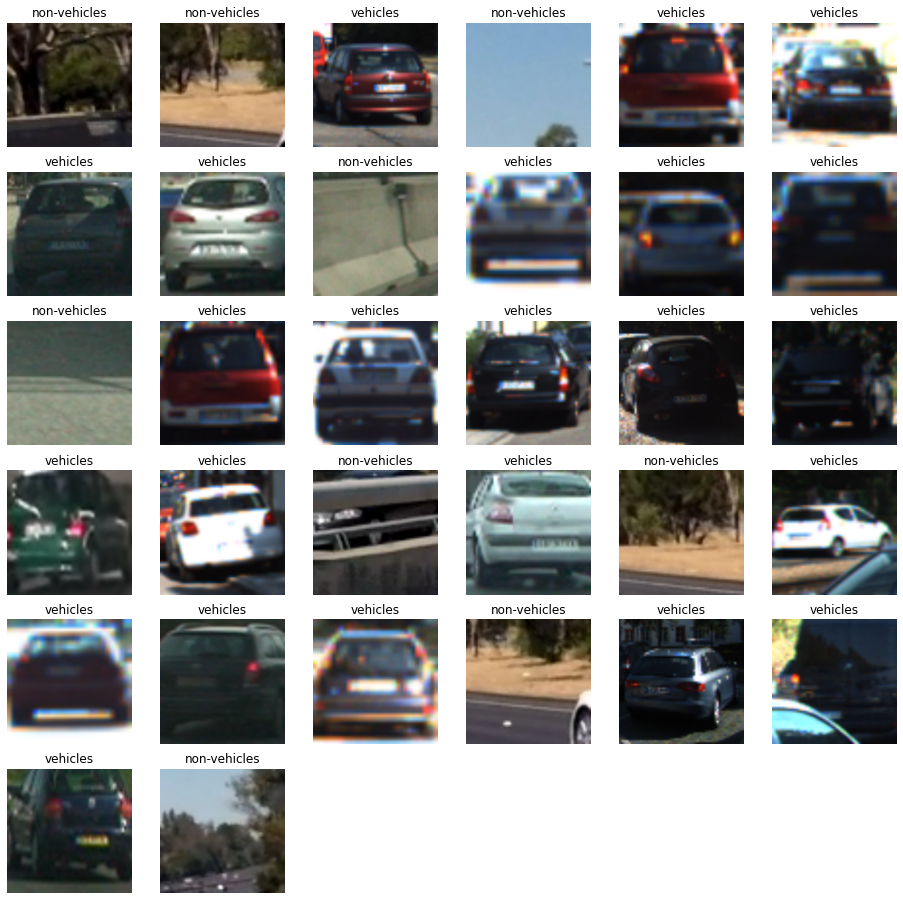

In [87]:
plt.figure(figsize=(16, 16))
for i in range(32):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [88]:
#Classification report for the first batch

print(classification_report(predictions,label_batch))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



<AxesSubplot:>

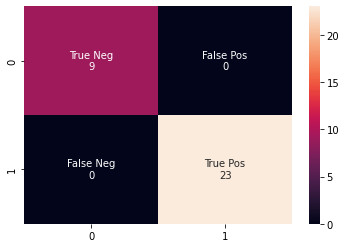

In [89]:
cf_matrix = confusion_matrix(predictions, label_batch)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="")


In [91]:
all_preds=[]
all_labels=[]
for x in range(len(test_dataset)) : 
    for image_batch, label_batch in test_dataset.as_numpy_iterator():
         pred = model.predict_on_batch(image_batch).flatten()
         preds = tf.where(pred < 0, 0, 1)
         all_preds.extend(preds)
         all_labels.extend(label_batch)

In [92]:
print(classification_report(all_preds,all_labels))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7469
           1       0.97      0.97      0.97      8019

    accuracy                           0.96     15488
   macro avg       0.96      0.96      0.96     15488
weighted avg       0.96      0.96      0.96     15488



<AxesSubplot:>

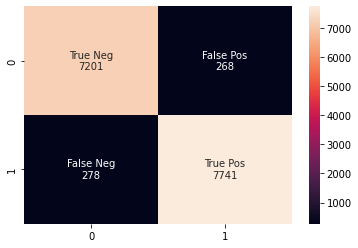

In [93]:
cf_matrix = confusion_matrix(all_preds, all_labels)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt="")


## Resnet model

In [ ]:
# acc = history2.history['accuracy']
# val_acc = history2.history['val_accuracy']

# loss = history2.history['loss']
# val_loss = history2.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.5])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
# image_batch2, label_batch2 = test_dataset.as_numpy_iterator().next()
# predictions2 = model2.predict_on_batch(image_batch2).flatten()

In [ ]:
# predictions2 = np.round(predictions2).astype(int)
# predictions2

In [ ]:
# label_batch2

In [ ]:
# plt.figure(figsize=(16, 16))
# for i in range(32):
#   ax = plt.subplot(6, 6, i + 1)
#   plt.imshow(image_batch2[i].astype("uint8"))
#   plt.title(class_names[predictions2[i]])
#   plt.axis("off")

In [ ]:
# #Classification report for the first batch

# print(classification_report(predictions2,label_batch2))

In [ ]:
# cf_matrix = confusion_matrix(predictions2, label_batch2)
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_names,group_counts)]

# labels = np.asarray(labels).reshape(2,2)

# sns.heatmap(cf_matrix, annot=labels, fmt="")

In [ ]:
# all_preds2=[]
# all_labels2=[]
# for x in range(len(test_dataset)) : 
#     for image_batch, label_batch in test_dataset.as_numpy_iterator().next():
#          pred = model.predict_on_batch(image_batch).flatten()
#          preds = np.round(predictions).astype(int)
#          all_preds2.extend(preds)
#          all_labels2.extend(label_batch)

In [ ]:
# print(classification_report(all_preds2,all_labels2))

In [ ]:
# cf_matrix = confusion_matrix(all_preds2, all_labels2)
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_names,group_counts)]

# labels = np.asarray(labels).reshape(2,2)

# sns.heatmap(cf_matrix, annot=labels, fmt="")


In [ ]:
# tf.keras.models.save_model(model,'saved_model/tansfer_model.h5' )